In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import pickle
import autocorrect
from autocorrect import Speller
import emoji

### 1.Problem Statement : Create a model to predict the emotion based on the given comment

### 2.Data Collection : Collected the dataset from Kaggle website

In [2]:
data=pd.read_csv(r"C:\Users\yuges\Downloads\Emotion_classify_Data.csv")

In [3]:
datac=data.copy()

In [4]:
datac

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
...,...,...
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear


### 3.EDA 

In [5]:
datac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [6]:
datac.shape # No missing values

(5937, 2)

In [7]:
datac[datac.duplicated()] # No duplicates

,Comment,Emotion


In [8]:
datac["Emotion"].value_counts() # Dataset is slightly imbalanced

anger    2000
joy      2000
fear     1937
Name: Emotion, dtype: int64

In [9]:
datac.describe()

,Comment,Emotion
count,5937,5937
unique,5934,3
top,i feel like a tortured artist when i talk to her,anger
freq,2,2000


In [10]:
fv=datac.iloc[:,0] # Seperating the feature variables and class labels
cl=datac.iloc[:,1]

## 4.Text Preprocessing

In [11]:
"".join(fv).islower() # Data is in lower case

True

In [12]:
fv.apply(lambda x:True if re.findall("<.+?>",x) else False).sum() # No html tags

0

In [13]:
fv.apply(lambda x:True if re.findall("http[s]?:\/\/.+? +",x) else False).sum() # No urls

0

In [14]:
fv.apply(lambda x:True if re.search("[0-9,\.?/:;\"\{\[\}\]<>|\\\+\-\*\/=_\)\(&\^%$#@!~`]",x) else False).sum() 
# No special characters and numbers

0

In [15]:
# Removing the stop words as we don't need them

In [16]:
stp=stopwords.words("english")

In [17]:
stp.remove("not")

In [18]:
def advpp(x):
    l=[]
    for word in x.split():
        if word in stp:
            pass
        else:
            l.append(word)
    return " ".join(l)

In [19]:
fv=fv.apply(advpp)

In [20]:
# No need of spelling correction and emoji conversion as our text don't have any emojis
# Stemming is necessary as we want only the words but not in present, past or future tense

In [21]:
def stem(x):
    l=[]
    wl=WordNetLemmatizer()
    for word in x.split():
        l.append(wl.lemmatize(word,pos="v"))
    return " ".join(l)

In [22]:
fv=fv.apply(stem)

In [23]:
fv

0       seriously hate one subject death feel reluctan...
1                                 im full life feel appal
2       sit write start dig feel think afraid accept p...
3       ive really angry r feel like idiot trust first...
4       feel suspicious one outside like rapture happe...
                              ...                        
5932                                  begin feel distress
5933      leave feel annoy angry think center stupid joke
5934    ever get marry everything ready offer get toge...
5935    feel reluctant apply want able find company kn...
5936             want apologize feel like heartless bitch
Name: Comment, Length: 5937, dtype: object

### 5.EDA to understand the data

In [24]:
eda_data=pd.concat([fv,cl],axis=1)

In [25]:
eda_data

,Comment,Emotion
0,seriously hate one subject death feel reluctan...,fear
1,im full life feel appal,anger
2,sit write start dig feel think afraid accept p...,fear
3,ive really angry r feel like idiot trust first...,joy
4,feel suspicious one outside like rapture happe...,fear
...,...,...
5932,begin feel distress,fear
5933,leave feel annoy angry think center stupid joke,anger
5934,ever get marry everything ready offer get toge...,joy
5935,feel reluctant apply want able find company kn...,fear


In [26]:
gb=eda_data.groupby("Emotion")

In [27]:
import wordcloud

In [28]:
from wordcloud import WordCloud

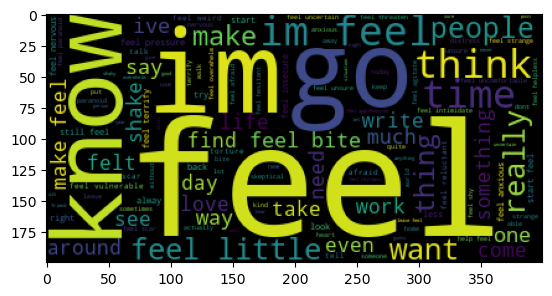

In [29]:
wc=WordCloud().generate(" ".join(gb.get_group("fear")["Comment"]))
plt.imshow(wc)
plt.show()

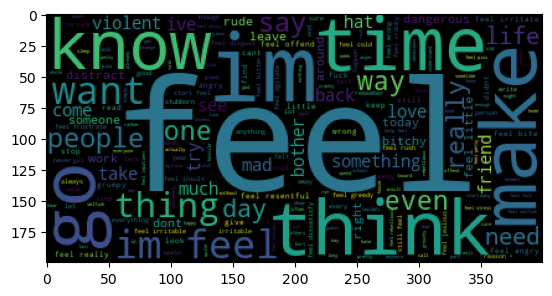

In [30]:
wa=WordCloud().generate(" ".join(gb.get_group("anger")["Comment"]))
plt.imshow(wa)
plt.show()

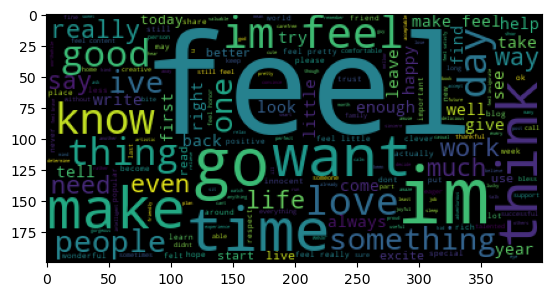

In [31]:
wj=WordCloud().generate(" ".join(gb.get_group("joy")["Comment"]))
plt.imshow(wj)
plt.show()

In [32]:
# Now we have preprocessed data and we can split the data for training and testing

In [33]:
cl=cl.map({"fear":0,"anger":1,"joy":2})

In [34]:
cl

0       0
1       1
2       0
3       2
4       0
       ..
5932    0
5933    1
5934    2
5935    0
5936    1
Name: Emotion, Length: 5937, dtype: int64

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
x_train,x_test,y_train,y_test=train_test_split(fv,cl,test_size=0.2,random_state=1,stratify=cl)

In [37]:
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=1,stratify=y_train)

### 6.Feature Extraction

In [38]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [39]:
cv=CountVectorizer(binary=True,ngram_range=(1,2)) # Binary Bag of words with 1-gram and 2-gram

In [40]:
bbow=cv.fit_transform(x_train) # Learning and transforming your x_train data using binary bag of words

In [41]:
xcv_bbow=cv.transform(x_cv) # Transforming the data of x_cv based on the learning of x_train data to make it unseen
xtest_bbow=cv.transform(x_test) # Transforming the data of x_test based on the learning of x_train data to make it unseen data

In [42]:
bbow

<3799x30286 sparse matrix of type '<class 'numpy.int64'>'
	with 66872 stored elements in Compressed Sparse Row format>

In [43]:
cv1=CountVectorizer(ngram_range=(1,2)) # Bag of words with 1-gram and 2-gram

In [44]:
bow=cv1.fit_transform(x_train) # Learning and transforming your x_train data using bag of words

In [45]:
bow

<3799x30286 sparse matrix of type '<class 'numpy.int64'>'
	with 66872 stored elements in Compressed Sparse Row format>

In [46]:
xcv_bow=cv1.transform(x_cv)
xtest_bow=cv1.transform(x_test)

In [47]:
tf=TfidfVectorizer(ngram_range=(1,2)) # TF-IDF with 1 and 2 gram

In [48]:
TFIDF=tf.fit_transform(x_train).toarray() # Learning and transforming your x_train data using tfidf 

In [49]:
tf_cv=tf.transform(x_cv).toarray()
tf_test=tf.transform(x_test).toarray()

### 7.Training and Evaluation

In [50]:
from sklearn.naive_bayes import BernoulliNB,MultinomialNB,CategoricalNB,GaussianNB
from sklearn.metrics import accuracy_score

In [51]:
tr_error=[]
cv_error=[]
for i in range(1,31):
    b=BernoulliNB(alpha=i)
    model=b.fit(bbow,y_train)
    predict=model.predict(xcv_bbow)
    predict_tr=model.predict(bbow)
    tr_error.append(1-accuracy_score(predict_tr,y_train))
    cv_error.append(1-accuracy_score(predict,y_cv))

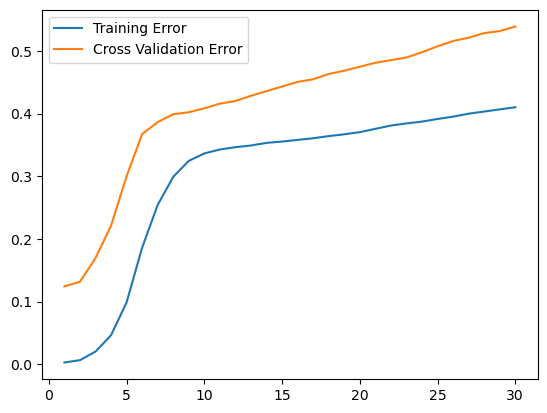

In [52]:
plt.plot(range(1,31),tr_error,label="Training Error")
plt.plot(range(1,31),cv_error,label="Cross Validation Error")
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import confusion_matrix

In [54]:
# As at alpha=1 my training error and cross validation error is low so i can choose alpha=1
# For Binary Bag of words we need to use Bernoulli naive bayes
b=BernoulliNB()
model=b.fit(bbow,y_train)
predict=model.predict(xtest_bbow)
print(confusion_matrix(y_test,predict))

[[349  30   9]
 [ 14 378   8]
 [ 16  40 344]]


In [55]:
tr_error=[]
cv_error=[]
for i in range(1,31):
    m=MultinomialNB(alpha=i)
    model=m.fit(bow,y_train)
    pre_tr=model.predict(bow)
    pre_cv=model.predict(xcv_bow)
    tr_error.append(1-accuracy_score(pre_tr,y_train))
    cv_error.append(1-accuracy_score(pre_cv,y_cv))

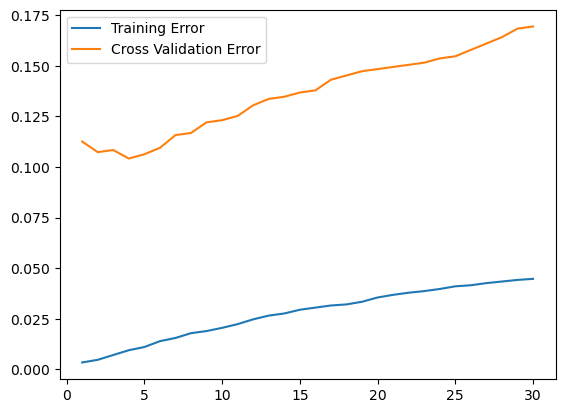

In [56]:
plt.plot(range(1,31),tr_error,label="Training Error")
plt.plot(range(1,31),cv_error,label="Cross Validation Error")
plt.legend()
plt.show()

In [57]:
# At alpha=1 we have low error so using alpha=1 i'm creating my multinomial Naive Bayes model
# For bag of words we need to use multinomial naive bayes
m=MultinomialNB(alpha=1)
model=m.fit(bow,y_train)
pre=model.predict(xtest_bow)
print(confusion_matrix(y_test,pre))

[[358  22   8]
 [ 22 367  11]
 [ 17  30 353]]


In [58]:
tr_error=[]
cv_error=[]
for i in range(1,31):
    m=MultinomialNB(alpha=i)
    model=m.fit(TFIDF,y_train)
    pre_tr=model.predict(TFIDF)
    pre_cv=model.predict(tf_cv)
    tr_error.append(1-accuracy_score(pre_tr,y_train))
    cv_error.append(1-accuracy_score(pre_cv,y_cv))

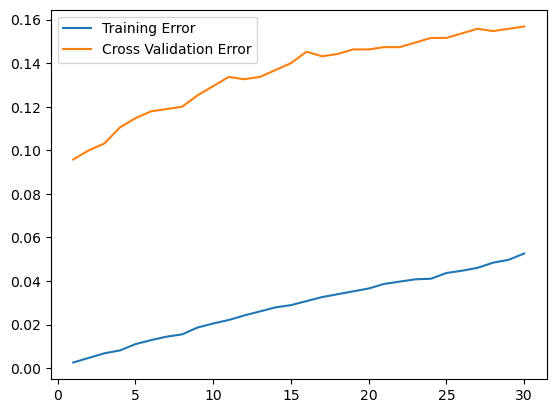

In [59]:
plt.plot(range(1,31),tr_error,label="Training Error")
plt.plot(range(1,31),cv_error,label="Cross Validation Error")
plt.legend()
plt.show()

In [60]:
# At alpha=1 we have low error so using alpha=1, i'm creating my multinomial Naive Bayes model
# For TF-IDF we use multinomial naive bayes or Guassian naive bayes
m=MultinomialNB(alpha=1)
model=m.fit(TFIDF,y_train)
pre=model.predict(tf_test)
print(confusion_matrix(y_test,pre))

[[354  25   9]
 [ 21 366  13]
 [  8  23 369]]


In [61]:
tr_error=[]
cv_error=[]
g=GaussianNB(var_smoothing=1)
model=g.fit(TFIDF,y_train)
pre_tr=model.predict(TFIDF)
pre_cv=model.predict(tf_cv)
tr_error.append(1-accuracy_score(pre_tr,y_train))
cv_error.append(1-accuracy_score(pre_cv,y_cv))

In [62]:
prediction=model.predict(tf_test)
print(confusion_matrix(y_test,prediction))

[[365  22   1]
 [ 29 364   7]
 [ 58  51 291]]


In [63]:
# As we have total 3 classes i.e. fear,angry and joy we can't find TP,FP,TN,FN values so we can't use precision, recall, f1-score, roc_curve metrics to check the performance of the model.

In [64]:
model

GaussianNB(var_smoothing=1)

### From the above models, we can use multinomial naive bayes with TF-IDF encoding as it is giving more accuracy

In [65]:
x_train=pd.DataFrame(x_train)
x_cv=pd.DataFrame(x_cv)
x_test=pd.DataFrame(x_test)

In [66]:
m=MultinomialNB(alpha=1)
model=m.fit(TFIDF,y_train)

In [67]:
pre=model.predict(tf_test)
print(accuracy_score(pre,y_test)*100) # Means my multinomial naive bayes with TF-IDF is giving more accuracy

91.66666666666666


In [68]:
confusion_matrix(y_test,pre)

array([[354,  25,   9],
       [ 21, 366,  13],
       [  8,  23, 369]], dtype=int64)

In [216]:
a=pd.Series(["I am rude"])

In [217]:
b=tf.transform(a)

In [218]:
model.predict(b) # 0 for fear, 1 for angry and 2 for joy

array([1], dtype=int64)

In [219]:
# My model is predicting angry for "I am rude"

### 8.Deployment

In [3]:
data

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
...,...,...
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear


In [4]:
fv=data.iloc[:,0]
cl=data.iloc[:,1]
cl=cl.map({"fear":0,"anger":1,"joy":2})

In [5]:
# To convert uppercase to lower if user gives uppercase as input
# user defined function is applied on FunctionTransformer and function transformer accept data in series only
def lower(x):
    return x.str.lower()

In [6]:
def em(x):
    x=x.apply(lambda x:emoji.demojize(x))
    return x

In [7]:
def html(x):
    return x.apply(lambda x:re.sub("<.+?>","",x))

In [8]:
def url(x):
    return x.apply(lambda x:re.sub("http[s]?:\/\/.+? +","",x))

In [9]:
def unw(x):
    return x.apply(lambda x:re.sub("[0-9,\.?/:;\"\'\{\[\}\]<>|\\\+\-\*\/=_\)\(&\^%$#@!~`]","",x))

In [10]:
def spell(x):
    s=Speller(lang="en")
    x=x.apply(lambda x:s(x))
    return x

In [11]:
def lemma(x):
    stp=stopwords.words("english")
    stp.remove("not")
    wl=WordNetLemmatizer()
    word_list=x.split()
    f_words=[wl.lemmatize(word,pos="v") for word in word_list if word not in stp]
    return " ".join(f_words)

In [12]:
# Now creating a pipeline as
pipe=Pipeline([("Lower",FunctionTransformer(lower)),("Emoji",FunctionTransformer(em)),("html",FunctionTransformer(html)),("urls",FunctionTransformer(url)),("Unwanted",FunctionTransformer(unw)),("Spelling Correction",FunctionTransformer(spell)),("Stopwords removal, lemamtization and feature extraction",TfidfVectorizer(preprocessor=lemma,ngram_range=(1,2)))])
# As FunctionTransformer is applied to series only i am doing stop words removal,lemmatization and after converting that text to vectors using TF-IDF with 2-gram by including lemma function and 2-gram in tfidf algorithm

In [13]:
cl

0       0
1       1
2       0
3       2
4       0
       ..
5932    0
5933    1
5934    2
5935    0
5936    1
Name: Emotion, Length: 5937, dtype: int64

In [14]:
x_train,x_test,y_train,y_test=train_test_split(fv,cl,test_size=0.2,random_state=1,stratify=cl)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=1,stratify=y_train)

In [15]:
pipe

Pipeline(steps=[('Lower',
                 FunctionTransformer(func=<function lower at 0x000002036A2218A0>)),
                ('Emoji',
                 FunctionTransformer(func=<function em at 0x000002036A223420>)),
                ('html',
                 FunctionTransformer(func=<function html at 0x000002036A222E80>)),
                ('urls',
                 FunctionTransformer(func=<function url at 0x000002036A2231A0>)),
                ('Unwanted',
                 FunctionTransformer(func=<function unw at 0x000002036A223920>)),
                ('Spelling Correction',
                 FunctionTransformer(func=<function spell at 0x000002036A2234C0>)),
                ('Stopwords removal, lemamtization and feature extraction',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 preprocessor=<function lemma at 0x000002036A2232E0>))])

In [16]:
xtrain_P=pipe.fit_transform(x_train)

In [17]:
xcv_P=pipe.transform(x_cv)
xtest_P=pipe.transform(x_test)

In [18]:
# Now i had my preprocessed data and pipeline so i can create a multinomial naive bayes model with Tf-idf because of high accuracy
m=MultinomialNB(alpha=1)
model=m.fit(xtrain_P,y_train)

In [19]:
x_cvpre=model.predict(xcv_P)

In [20]:
accuracy_score(x_cvpre,y_cv)

0.9052631578947369

In [21]:
x_testpre=model.predict(xtest_P)

In [22]:
accuracy_score(x_testpre,y_test)

0.9124579124579124

In [45]:
data=pd.Series("Happy Birthday")
a=pipe.transform(data)

In [46]:
model.predict(a)

array([2], dtype=int64)

In [326]:
# Now i can dump my Multinomial naive bayes model with laplace smoothing 1 and my final pipeline as
pickle.dump(pipe,open(r"C:\Users\yuges\OneDrive\Desktop\emotionpipe.pkl","wb"))
pickle.dump(model,open(r"C:\Users\yuges\OneDrive\Desktop\emotionmodel.pkl","wb"))